In [29]:
import requests
import json
import ollama

url = "http://127.0.0.1:8000/query"
headers = {"Content-Type": "application/json"}
ollama.pull('llama3.1:8b') 

ProgressResponse(status='success', completed=None, total=None, digest=None)

## Get Answer of a Question ##

In [58]:
def get_response(query):
    response = requests.post(url, data=json.dumps({"query": query}), headers=headers)
    return response.json()

In [ ]:
def get_prompt(response):
    system_prompt = "You are a factual question-answering assistant specializing in information about Pittsburgh and Carnegie Mellon University (CMU).\nYour task is to provide accurate answers to questions about various facts concerning Pittsburgh and CMU.\nYou are given a user question and a context. Your task is to answer the question based on the retrieved documents in the context while also considering the chat history.\nDo not hallucinate or add extra information. Stick to the information provided in the retrieved documents.\nIf the retrieved documents do not contain information relevant to the question or if the information is irrelevant, then you shoud acknowledge that you don't have enough information to answer accurately.\nWrite in a clear, concise, and informative tone.\nDO not mention the source from where you got the information. If you get too much information, only use the information that you need to answer the question and ignore the rest."
    prompt = f"SYSTEM PROMPT:\n {system_prompt}\n ---------------------------\n"
    prompt += f"USER QUESTION:\n{response['query']}\n---------------------------\n"
    prompt += f"RETRIEVED DOCUMENTS:\n{response['context']}\n"
    prompt += f"---------------------------\nYour answer:"

    return prompt

def call_ollama(prompt):
    response = ollama.chat(model='llama3.1:8b', messages=[{"role": "user", "content": prompt}])
    return response.message.content

def get_answer(question):
    response = get_response(question)

    prompt = get_prompt(response)

    response = ollama.chat(model='llama3.1:8b', messages=[{"role": "user", "content": prompt}])

    return response.message.content

### Testings ###

In [109]:
question = "How many spinoff companies did CMU create in 2014?  "
print(get_answer(question))

RAG Response
{'query': 'How many spinoff companies did CMU create in 2014?  ', 'context': '39707: How many spinoff companies did CMU create in 2014?  \nA: 36.\n\n39688: How many companies have been launched from CMU?  \nA: Over 1,000 companies globally.\n\n39706: What major companies have set up operations in Pittsburgh due to CMU?  \nA: Google, Intel, Uber, and GE.'}
CMU created 36 spinoff companies in 2014.


In [44]:
question = "How many spinoff companies did CMU create in 2014?  "
print(get_answer(question))

RAG Response
{'query': 'How many spinoff companies did CMU create in 2014?  ', 'context': '39707: How many spinoff companies did CMU create in 2014?  \nA: 36.\n\n39688: How many companies have been launched from CMU?  \nA: Over 1,000 companies globally.\n\n39706: What major companies have set up operations in Pittsburgh due to CMU?  \nA: Google, Intel, Uber, and GE.'}
CMU created 36 spinoff companies in 2014.


## Evaluation Code ##

In [ ]:
import nltk
from nltk.corpus import stopwords
import string


nltk.download('stopwords')
print(stopwords.words('english'))
stop_words = set(stopwords.words('english'))

In [48]:
def remove_stop_words(text, stopwords):
    words = text.translate(str.maketrans('', '', string.punctuation)).split()

    word_set = set()

    for w in words:
        if w not in stopwords:
            word_set.add(w)
    
    return word_set


def get_confusion_matrix(gt, answer, stopwords):
    gt_set = remove_stop_words(gt, stopwords)
    answer_set = remove_stop_words(answer, stopwords)

    intersect = gt_set.intersection(answer_set)
    false_negative = gt_set - answer_set
    false_positive = answer_set - gt_set

    return len(intersect), len(false_negative), len(false_positive)

def calculate_metrics(gt, answer, stopwords):
    TP, FN, FP =  get_confusion_matrix(gt, answer, stopwords)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fnr = FN / (TP + FN) if (TP + FN) > 0 else 0
    
    return {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "False Negative Rate": fnr,
        "TP": TP,
        "FN": FN,
        "FP": FP
    }

In [47]:
def get_semantic_similarity(gt, answer, model):
    # Get sentence embeddings
    embedding1 = model.encode(gt, convert_to_tensor=True)
    embedding2 = model.encode(answer, convert_to_tensor=True)

    # Compute cosine similarity
    similarity = util.cos_sim(embedding1, embedding2)

    return similarity

In [ ]:
from sentence_transformers import SentenceTransformer, util


text = "I like that good apple, do you like it?"
gt = "I love apple, it is good"

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

## Evaluate ##

In [60]:
def load_QAs(file_dir):

    with open(file_dir, 'r') as f:
        data = f.readlines()
    
    num_lines = len(data)

    QA_pairs = []

    for i in range(num_lines//3):
        q = data[i*3].replace("Q: ", "")
        a = data[i*3+1].replace("A: ", "")

        QA_pairs.append((q,a))
    
    return QA_pairs


In [62]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

from tqdm import tqdm


# file_dir = "test_QAs.txt"

def get_eval_by_file(file_dir):

    QAs = load_QAs(file_dir)

    columns = ["Precision", "Recall", "F1 Score", "False Negative Rate", "TP", "FN", "FP", "Semantic Similarity"]
    df = pd.DataFrame(columns=columns)
    df_list = []

    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


    for q, a in tqdm(QAs):
        model_answer = get_answer(q)

        metrics = calculate_metrics(a, model_answer, stop_words)
        similarity = get_semantic_similarity(a, model_answer, model)
        metrics["Semantic Similarity"] = similarity.item()

        df_temp = pd.DataFrame([metrics])
        df_list.append(df_temp)
        
    df = pd.concat(df_list, ignore_index=True)
    return df


### Evaluate Each Settings ###

#### Evaluate Alibaba Model ####

In [ ]:
df_Alibaba_3 = get_eval_by_file("test_combined.txt")

In [ ]:
df_Alibaba_3["Model"] = "Alibaba"
df_Alibaba_3["Top-k"] = 3
df_Alibaba_3.to_csv("Alibaba_3.csv", index=True)

In [ ]:
df_Alibaba_1 = get_eval_by_file("test_combined.txt")

In [66]:
df_Alibaba_1["Model"] = "Alibaba"
df_Alibaba_1["Top-k"] = 1
df_Alibaba_1.to_csv("Alibaba_1.csv", index=True)

In [ ]:
# Measure average inference time
import time

QAs = load_QAs("test_combined.txt")

total_time = 0

for q,a in QAs:
    start_time = time.time()
    model_answer = get_answer(q)
    total_time += time.time() - start_time

total_time

In [70]:
total_time/len(QAs)

3.196448818618703

#### Evaluate Sentence_Transformer Model ####

In [ ]:
df_ST_1 = get_eval_by_file("test_combined.txt")
df_ST_1["Model"] = "ST"
df_ST_1["Top-k"] = 1
df_ST_1.to_csv("ST_1.csv", index=True)

In [ ]:
# Measure average inference time
import time

total_time_st_1 = 0

for q,a in QAs:
    start_time = time.time()
    model_answer = get_answer(q)
    total_time += time.time() - start_time

total_time_st_1

In [73]:
(total_time)/len(QAs) - 3.196448818618703

3.4861447743966547

In [ ]:
df_ST_3 = get_eval_by_file("test_combined.txt")
df_ST_3["Model"] = "ST"
df_ST_3["Top-k"] = 3
df_ST_3.to_csv("ST_3.csv", index=True)

### Test Functions ###

In [54]:
df = pd.concat(df_list, ignore_index=True)
df

,Precision,Recall,F1 Score,False Negative Rate,TP,FN,FP,Semantic Similarity
0,0.250000,0.333333,0.285714,0.666667,1,2,3,0.419860
1,0.785714,0.611111,0.687500,0.388889,11,7,3,0.707158
2,0.222222,0.500000,0.307692,0.500000,2,2,7,0.594896
3,0.250000,1.000000,0.400000,0.000000,3,0,9,0.621175
4,0.000000,0.000000,0.000000,1.000000,0,4,10,0.194657
5,0.100000,0.250000,0.142857,0.750000,1,3,9,0.524587
6,0.081081,0.214286,0.117647,0.785714,3,11,34,0.834664
7,0.363636,0.923077,0.521739,0.076923,12,1,21,0.804906
8,0.166667,0.500000,0.250000,0.500000,5,5,25,0.903842
9,0.222222,0.500000,0.307692,0.500000,2,2,7,0.566965


In [56]:
df = pd.concat(df_list, ignore_index=True)
df

,Precision,Recall,F1 Score,False Negative Rate,TP,FN,FP,Semantic Similarity
0,0.083333,0.333333,0.133333,0.666667,1,2,11,0.311564
1,0.785714,0.611111,0.687500,0.388889,11,7,3,0.707158
2,0.250000,0.500000,0.333333,0.500000,2,2,6,0.605369
3,0.157895,1.000000,0.272727,0.000000,3,0,16,0.558117
4,0.000000,0.000000,0.000000,1.000000,0,4,10,0.194657
5,0.100000,0.250000,0.142857,0.750000,1,3,9,0.524587
6,0.076923,0.071429,0.074074,0.928571,1,13,12,0.769841
7,0.923077,0.923077,0.923077,0.076923,12,1,1,0.976824
8,0.230769,0.600000,0.333333,0.400000,6,4,20,0.872676
9,0.222222,0.500000,0.307692,0.500000,2,2,7,0.566965


## Visualization ##

In [75]:
df_a_1 = pd.read_csv("Alibaba_1.csv")
df_s_1 = pd.read_csv("ST_1.csv")
df_a_3 = pd.read_csv("Alibaba_3.csv")
df_s_3 = pd.read_csv("ST_3.csv")

In [85]:
def load_categories(file_dir = "categorized_questions.txt"):
    with open(file_dir, 'r') as f:
        data  = f.readlines()
    
    category = []
    for row in data:
        if "Augment_Better" in row or "Augment_Required" in row or "LLM_Ready" in row or "Temporal_Sensitive" in row:
            category.append(row.strip())

    return category

In [86]:
categories = load_categories()

In [88]:
df_a_1["category"] = categories
df_a_3["category"] = categories
df_s_1["category"] = categories
df_s_3["category"] = categories

df = pd.concat([df_a_1, df_a_3, df_s_1, df_s_3], ignore_index=True)


In [89]:
df.head()

,Unnamed: 0,Precision,Recall,F1 Score,False Negative Rate,TP,FN,FP,Semantic Similarity,Model,Top-k,category
0,0,0.250000,0.333333,0.285714,0.666667,1,2,3,0.419860,Alibaba,1,Augment_Better
1,1,0.666667,0.555556,0.606061,0.444444,10,8,5,0.691959,Alibaba,1,Augment_Better
2,2,0.500000,0.750000,0.600000,0.250000,3,1,3,0.667408,Alibaba,1,LLM_Ready
3,3,0.600000,1.000000,0.750000,0.000000,3,0,2,0.719763,Alibaba,1,Augment_Required
4,4,0.000000,0.000000,0.000000,1.000000,0,4,10,0.194657,Alibaba,1,Augment_Better


In [91]:
grouped_df_model = df.groupby(['Model', 'Top-k'])[['Precision', "Recall", "F1 Score", "False Negative Rate", "Semantic Similarity"]].mean().reset_index()
grouped_df_model

,Model,Top-k,Precision,Recall,F1 Score,False Negative Rate,Semantic Similarity
0,Alibaba,1,0.256307,0.658284,0.335221,0.341716,0.482806
1,Alibaba,3,0.250710,0.694014,0.336966,0.305986,0.492929
2,ST,1,0.248454,0.663260,0.328536,0.336740,0.481117
3,ST,3,0.250943,0.688307,0.337264,0.311693,0.487553


/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr

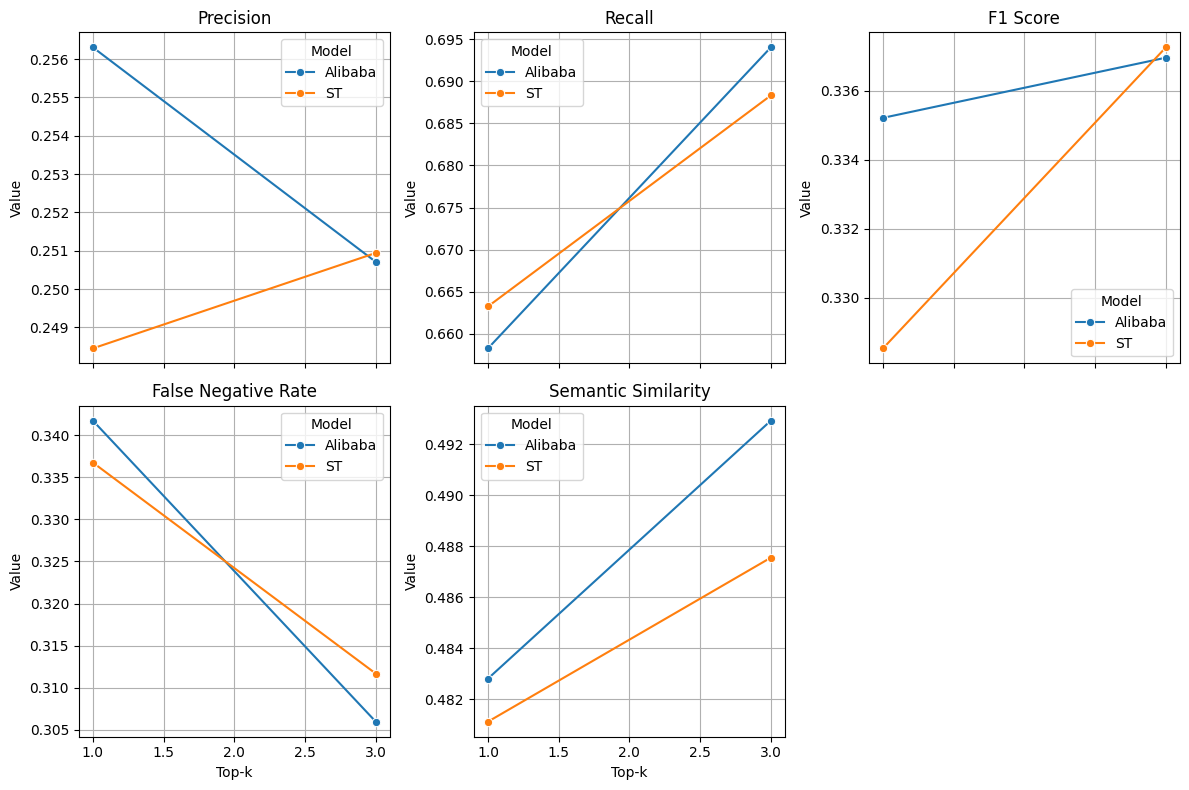

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["Precision", 'Recall', 'F1 Score', 'False Negative Rate', 'Semantic Similarity']

fig, axes = plt.subplots(2, 3, figsize=(12, 8),  sharex=True, constrained_layout=True)

axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(
        data=df, x='Top-k', y=metric, hue='Model', marker='o', ax=axes[i], ci=None
    )
    axes[i].set_title(metric)
    axes[i].set_ylabel("Value")
    axes[i].set_xlabel("Top-k")

    axes[i].grid(True)
    
axes[-1].set_visible(False)

plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase vertical and horizontal spacing
plt.tight_layout() 
plt.show()

In [104]:
grouped_df_category = df.groupby(['category'])[['Precision', "Recall", "F1 Score", "False Negative Rate", "Semantic Similarity"]].mean().reset_index()
grouped_df_category

,category,Precision,Recall,F1 Score,False Negative Rate,Semantic Similarity
0,Augment_Better,0.340502,0.705291,0.422443,0.294709,0.576602
1,Augment_Required,0.241225,0.560715,0.311222,0.439285,0.458609
2,LLM_Ready,0.189542,0.799094,0.283966,0.200906,0.449567
3,Temporal_Sensitive,0.304004,0.734018,0.406808,0.265982,0.532379


## Generate Answer ##

In [113]:
import csv

with open("test_set.csv", newline="") as csvfile:
    reader = csv.reader(csvfile)
    questions = [row for row in reader]

len(questions)

575

In [ ]:
answers = {}
count = 1
for q in tqdm(questions):
    a = get_answer(q[0])

    answers[str(count)] = a

    count += 1

In [120]:
import json

with open("system_output.json", "w") as json_file:
    json.dump(answers, json_file, indent=4)

In [121]:
len(answers)

575

In [123]:
miss_info_questions = ['Which festival celebrates Latin-American culture in Pittsburgh?',
                       'What public art project by the Pittsburgh Cultural Trust is named after a sudden meteorological event?',
                       "According to the Pittsburgh City Paper's Best Of PGH 2024, where can you find the best African food?",
                       '"Where is Sheku Kanneh-Mason playing on March 22, 2025?"']
answers_miss_info = []
for q in tqdm(miss_info_questions):
    a = get_answer(q[0])
    answers_miss_info.append(a)

  0%|          | 0/4 [00:00<?, ?it/s]

RAG Response
{'query': 'W', 'context': '**Event: Wednesday Morning Walk**\n32822: When does the Wednesday Morning Walk event occur?\nA: Wednesdays.\n\n31535: Which song by Wiz Khalifa is associated with the Pittsburgh Steelers?\nA: "Black and Yellow"\n\n25503: What is the name of the park with an overlook mentioned in the text?\nA: West End Overlook\n\n33995: Who hit the walk-off home run to win the 1960 World Series for the Pirates?\nA: Bill Mazeroski hit the walk-off home run.\n\n31476: What song by Wiz Khalifa is part of the Steelers home game experience?\nA: "Black and Yellow."\n\n32825: What is the description of the Wednesday Morning Walk event?\nA: It is a naturalist-led walk that takes place rain or shine.\n\n29404: Which Pittsburgh-based artist had a Billboard Hot 100 number one hit with "Black and Yellow" in 2011?\nA: Wiz Khalifa.\n\n29558: Which Pittsburgh-based musician had a hit with "Black and Yellow" reaching number one on the Billboard Hot 100 in 2011?\nA: Wiz Khalifa.\

 25%|██▌       | 1/4 [00:30<01:31, 30.48s/it]

RAG Response
{'query': 'W', 'context': '**Event: Wednesday Morning Walk**\n32822: When does the Wednesday Morning Walk event occur?\nA: Wednesdays.\n\n31535: Which song by Wiz Khalifa is associated with the Pittsburgh Steelers?\nA: "Black and Yellow"\n\n25503: What is the name of the park with an overlook mentioned in the text?\nA: West End Overlook\n\n33995: Who hit the walk-off home run to win the 1960 World Series for the Pirates?\nA: Bill Mazeroski hit the walk-off home run.\n\n31476: What song by Wiz Khalifa is part of the Steelers home game experience?\nA: "Black and Yellow."\n\n32825: What is the description of the Wednesday Morning Walk event?\nA: It is a naturalist-led walk that takes place rain or shine.\n\n29404: Which Pittsburgh-based artist had a Billboard Hot 100 number one hit with "Black and Yellow" in 2011?\nA: Wiz Khalifa.\n\n29558: Which Pittsburgh-based musician had a hit with "Black and Yellow" reaching number one on the Billboard Hot 100 in 2011?\nA: Wiz Khalifa.\

 50%|█████     | 2/4 [00:33<00:28, 14.07s/it]

RAG Response
{'query': 'A', 'context': "A: $100.\n\nA: $100.\n\n26733: Who founded the Mellon Institute of Industrial Research?\nA: Andrew Mellon and Richard B. Mellon\n\n785: Who founded Carnegie Mellon University?\nA: Andrew Carnegie, Andrew Mellon, and Richard B. Mellon.\n\n686: Who founded Carnegie Mellon University?\nA: Andrew Carnegie, Andrew Mellon, and Richard B. Mellon\n\n1009: Who were the founders of Carnegie Mellon University?\nA: Andrew Carnegie, Andrew Mellon, and Richard B. Mellon\n\n26753: Who founded the Mellon Institute of Industrial Research?\nA: Andrew Mellon and Richard B. Mellon\n\n33391: Where does Pittsburgh's Best St. Patrick's Day Weekend Bar Crawl take place?\nA: Josh D Pittsburgh, Pittsburgh Oakland.\n\n895: Who founded Carnegie Mellon University?\nA: Andrew Carnegie, Andrew Mellon, and Richard B. Mellon.\n\n36114: Where will the Befriending the Forest event take place?\nA: Hays Woods Park, Agnew Rd, Baldwin Mt. Oliver."}


 75%|███████▌  | 3/4 [00:43<00:12, 12.40s/it]

RAG Response
{'query': '"', 'context': 'A: $100.\n\nA: $100.\n\nfiled at this time. the incident occurred on january 31, 2018. police are urging anyone involved or with information to come forward. ###\n11151: Who is handling the investigation of the officer-involved shooting?\nA: The investigation is being handled by the Allegheny County Police.\n\n19961: What incident led to a police officer firing a shot on July 15, 2018?\nA: A police officer fired a shot during an incident involving a suspect armed with a handgun after a man was pistol-whipped on the 2400 block of Charcot Street.\n\n13510: What type of crimes are excluded from the data set in the new crime data portal?\nA: Violent crimes of a sexual nature are excluded.\n\n37996: How much are tickets for the "B!tch Please" event?\nA: $15.00\n\n5606: How can participants and mentors register for the late-night basketball initiative?\nA: They can register through a link provided in the text: https://forms.office.com/pages/responsepag

100%|██████████| 4/4 [00:56<00:00, 14.10s/it]


In [125]:
missing_info_qs = []


for key in answers.keys():
    if "I don't have enough information" in answers[key] or "not able" in answers[key]:
        missing_info_qs.append(questions[int(key)-1])

In [127]:
text_missing = [x[0] for x in missing_info_qs]
text_missing

['Which festival celebrates Latin-American culture in Pittsburgh?',
 'Whose work does the Uncommon Perfection event at CMU highlight?',
 'How many suites does PNC Park have?',
 'What section of the Payroll Tax regulations defines taxpayer responsibilities?',
 'Which event promotes literacy through a food fair in Pittsburgh?',
 "According to the Pittsburgh City Paper's Best Of PGH 2024, where can you find the best African food?",
 'Who is the Vice President of Ticket Operations for the Pittsburgh Steelers?',
 'What ballet performance will be at the Byham Theater on May 7, 2025?',
 "According to the Pittsburgh City Paper's Best Of PGH 2024, where can you find the best BBQ?",
 'How many home run balls have exited PNC Park?',
 'What event hosts a celebrity bocce challenge in Pittsburgh?',
 'What artist is coming to the Event Center at Rivers Casino Pittsburgh on March 28, 2025?',
 'Which Pittsburgh event includes workshops and educational demonstrations?',
 'Which Pittsburgh event is sched